In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [2]:
import os

# Customised for Andy's setup
os.chdir('SharedFiles/MAST30034-Group-Project/')

In [3]:
# labels_path = os.join()

# Customised for Andy's setup
labels = pd.read_csv("kaggle_bee_vs_wasp/labels.csv")
labels['path'] = labels['path'].str.replace("\\", "/")

By removing the low quality photos, we get rid of the is_other instances

In [4]:
high_quality_entries = labels[labels["photo_quality"] == 1]

In [5]:
print(high_quality_entries.shape)
high_quality_entries.head()

(7035, 10)


,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1/10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1/10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1/10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1/1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1/10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [6]:
np.unique(high_quality_entries["label"], return_counts = True)

(array(['bee', 'insect', 'wasp'], dtype=object), array([2469, 2439, 2127]))

In [7]:
# no non-insects found in the dataset
list(high_quality_entries["is_other"]).count(1)

0

In [8]:
from sklearn.model_selection import train_test_split

images_path = high_quality_entries["path"].values.reshape(-1, 1)
labels = high_quality_entries["label"].values.reshape(-1, 1)
images_train_path, images_test_path, label_train, label_test = train_test_split(images_path, labels, test_size = 0.3, random_state = 30034, stratify = labels)

# Data

In [9]:
from matplotlib.image import imread

In [10]:
images = []

for image_path in images_train_path:
    #image_path = image_path.replace("\\", "/")
    images.append(imread(os.path.join("kaggle_bee_vs_wasp", image_path[0])))
    
print(len(images), 'images were read.')

4924 images were read.


In [11]:
# #If you need to check the images.

# #imread outputs integers between 0-255

# #images[0]
# f,ax = plt.subplots(3,3)
# for i in range(3):
#     for j in range(3):
#         ax[i,j].imshow(images[i+3*j])

## Resize

In [12]:
from skimage.transform import resize

In [13]:
# resize images to 224 x 224 
for im in range(len(images)):
    images[im] = resize(images[im], (224,224))
    if images[im].shape != (224,224,3):
        print(im)

2538
4163


In [14]:
# Skimage outputs floats between 0-1

#print(images[0])

## Remove 1 image, manually change another

In [15]:
images_train_path[4163]

array(['bee1/509769820_83fa0a3ea9_n.jpg'], dtype=object)

The images are supposed to have 3 channels - RGB

There are 2 anomalous images.
Image 2538 ('wasp1/50988238_1c313384d9_n.jpg') is black and white (1-channel)

Image 4163 ('bee1/509769820_83fa0a3ea9_n.jpg') has an extra channel for transparency, which can be removed.

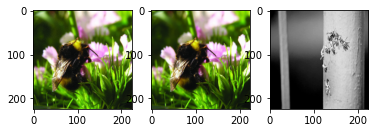

In [16]:
f, ax = plt.subplots(1,3)

# left: Original
ax[0].imshow(images[4163])

# middle: Transparency removed, still the same
ax[1].imshow(images[4163][:,:,0:3])

# right: This is how the original looks like in the file.
# I had to subtract and add greys to reproduce it here for convenience.
ax[2].imshow(-images[2538], cmap='Greys')

In [17]:
#remove the 4th channel for the other
images[4163] = images[4163][:,:,0:3]
    
# Delete the black and white one,
del images[2538]
label_train_deleted = np.delete(label_train, [2538])

print('number of images in data:', len(images))

number of images in data: 4923


## Encoding the image labels

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
# Encode as integers
encoder = LabelEncoder()
transformed_label = encoder.fit_transform(np.ravel(label_train_deleted))
print(transformed_label[0:6])

print('number of labels:', len(transformed_label))

[2 2 0 1 0 2]
number of labels: 4923


# Data augmentation

Split a training set from a validation set first, to prevent data leakage.
Augment a training set.

https://stats.stackexchange.com/questions/175504/how-to-do-data-augmentation-and-train-validate-split

In [20]:
image_array = np.array(images)
image_array.shape

(4923, 224, 224, 3)

In [21]:
#Train/validation split


Xtrain, Xval, Ytrain, Yval = train_test_split(image_array, transformed_label, 
                                              test_size = 0.25, random_state = 30034, 
                                              stratify = transformed_label)

print(Xtrain.shape, Ytrain.shape)
print(Xval.shape, Yval.shape)

(3692, 224, 224, 3) (3692,)
(1231, 224, 224, 3) (1231,)


In [22]:
# Augmented training data
train_generator = keras.preprocessing.image.ImageDataGenerator(
    #featurewise_center=True, featurewise_std_normalization=True,
    rotation_range=90,
    zoom_range=0.4,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    channel_shift_range=0.3
)

# No augmentation on validation
val_generator = keras.preprocessing.image.ImageDataGenerator()

train_generator.fit(Xtrain)

In [23]:
# # If images need to be viewed

# augmented_train = train_generator.flow(Xtrain, Ytrain, batch_size=32)

# for i in range(9):
#     # define subplot
#     plt.subplot(330 + 1 + i)
#     # generate batch of images
#     batch = augmented_images.next()
#     # convert to unsigned integers for viewing
#     image = batch[0]
#     # plot raw pixel data
#     image = np.reshape(image, (224,224,3))
#     plt.imshow(image)

# Prepare for model

In [24]:
# images = np.array(images)
# inputs = keras.applications.resnet50.preprocess_input(images) 

# Model - MobileNetV2 (baseline)

3692 images in a training set. Augmented images will be generated from this set for training.

1231 unaugmented images will be used for validation.

In [25]:
# OR baseline
print(np.unique(transformed_label, return_counts=True))
print(1728/len(transformed_label)) #35% is the baseline

(array([0, 1, 2]), array([1728, 1707, 1488]))
0.3510054844606947


In [26]:
mbnet = keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet')
avg = keras.layers.GlobalAveragePooling2D()(mbnet.output)
#drop = keras.layers.Dropout(0.7)(avg)
output = keras.layers.Dense(3, activation='softmax')(avg)

m0 = keras.Model(inputs = mbnet.input, outputs = output)

for layer in mbnet.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum= 0.9, decay = 0.01)

m0.compile(loss="sparse_categorical_crossentropy", 
           optimizer=optimizer,
           metrics=["accuracy"])

In [27]:
h0 = m0.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
            epochs=1, steps_per_epoch=100,
            validation_data = val_generator.flow(Xval, Yval, batch_size=32),
            validation_steps = int(len(Yval)/32))

100/100 [==============================] - 335s 3s/step - loss: 7.8968 - accuracy: 0.7556 - val_loss: 3.2772 - val_accuracy: 0.8446


In [28]:
m0.evaluate(Xval,Yval)

39/39 [==============================] - 85s 2s/step - loss: 3.3631 - accuracy: 0.8424


[3.363102674484253, 0.8424045443534851]

In [29]:
# Final (15 epochs): 84-86% in training, 80-86% in validation

# Model Design

Speeding up training:
* Batch normalisation, Adam optimisation

Design options
* Convolution: Window size, Stride
* Activation functions: Softmax, ReLU
* Pooling: Average, Max
* Dense layer - fully connected.

Regularisation options
* Dropout: for regularisation

Other options
* Residual block (resnet)
* Batch normalisation: makes models faster and more stable.

Design recommendations
* Multiple 3x3 convolutions are preferred.
* Downsample by using pooling to reduce spatial information
* Common paradigm is to use max pooling in the network, and average pooling at the end, before the last dense layer
* Depth tends to result in higher accuracy

After all this, try to augment the data:
* rotations
* flips
* slight colour changes (for lighting conditions)

In [ ]:
       
# Filter: number of filters to learn - to be specified
# kernel_size: height and width of filter - to be specified
# Strides = (1,1) by default (no skip).
# Padding (if a filter doesn't fit)
# Activation = 'relu' (applied after calculations)
# Bias = True by default
# Consider regularisers after
# m1.add(keras.layers.BatchNormalization())
# m1.add(keras.layers.Dropout(0.5))
# m1.add(keras.layers.Activation("relu"))
# m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
# m1.add(keras.layers.GlobalAvgPool2D())
# m1.add(keras.layers.Flatten())
# m1.add(keras.layers.Dense(10, activation="softmax"))


## Original Model

In [ ]:
m1 = keras.models.Sequential()

m1.add(keras.layers.Conv2D(128, 3, activation = 'relu', padding='same'))
m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
m1.add(keras.layers.BatchNormalization())

m1.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding='same'))
m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
m1.add(keras.layers.BatchNormalization())

m1.add(keras.layers.Conv2D(32, 3, activation = 'relu', padding='same'))
m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
m1.add(keras.layers.BatchNormalization())

m1.add(keras.layers.Conv2D(32, 3, activation = 'relu', padding='same'))
m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
m1.add(keras.layers.BatchNormalization())

m1.add(keras.layers.Conv2D(16, 3, activation = 'relu', padding='same'))
m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
m1.add(keras.layers.BatchNormalization())

m1.add(keras.layers.GlobalAveragePooling2D())
# m1.add(keras.layers.BatchNormalization())
m1.add(keras.layers.Dense(3, activation="softmax"))

#optimizer = keras.optimizers.SGD(lr=0.2, momentum= 0.9, decay = 0.01)

optimizer = keras.optimizers.Adam()

m1.compile(loss="sparse_categorical_crossentropy",
           optimizer=optimizer,
           metrics=["accuracy"])


In [ ]:
h1 = m1.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
            epochs=1, steps_per_epoch=100,
            validation_data = val_generator.flow(Xval, Yval, batch_size=32),
            validation_steps = int(len(Yval)/32))

# Assessment of model fit

Check for overfitting
Epoch vs. [Training accuracy, training loss, validation accuracy, validation loss]


To do: checkpointing on training. Want to be able to load a previous model and continue training
